In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mat_file = '1D_traveltime_data.mat'

M = sp.io.loadmat(mat_file)

In [3]:
d_obs = M['d_obs'].flatten()
d_std = M['d_std'].flatten()
G = M['G']
z_data = M['z_data'].flatten()
dz = M['dz'][0][0]
m0 = M['v0'].flatten().astype(float)
s0 = 1/m0
nm=len(m0)
# z=0,10,20,,,,290
z = np.arange(0,dz*nm,dz)

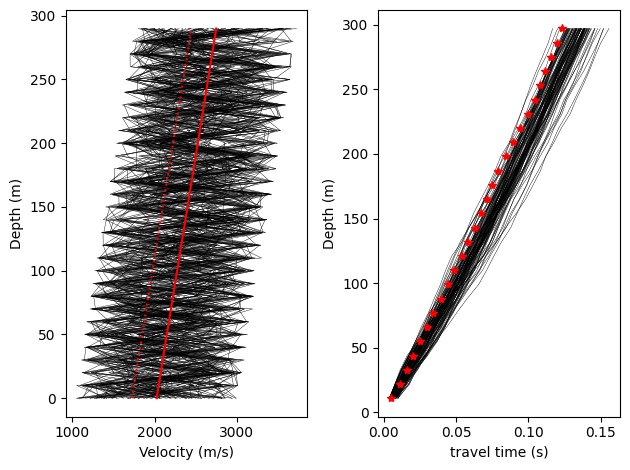

In [4]:
def forward_model(m, G):
    # compute d as a function of m
    s = 1/m
    d = np.dot(G, s)
    return d

def sample_prior(m_c = [], step=0.1, n_p=5):
    
    if len(m_c) == 0:
        r = 2000*(np.random.random(m0.shape)-.5)
        m_p = m0 + r
    else:
        # select a random sample of size n=5 from a seirs on number from 1 to 30
        i_pert = np.random.choice(nm, n_p, replace=False)

        r = step*(np.random.random(m_c.shape)-.5)
        r= step * np.random.randn(nm,1)
        r = r.flatten()
        m_p = m_c.copy()
        m_p[i_pert] = m_c[i_pert] + r[i_pert]
        m_diff = np.abs(m_p-m0)
        
        # find the number of modelparameters where dm is largner than 1000
        n_outside = len(np.where(m_diff>1000)[0])
        if n_outside>0:
            # print(n_outside)
            m_p = m_c
    return m_p

    
    
def likelihood(d, d_obs, d_std):
    useLog = True
    f = -0.5 * np.sum((d_obs - d) ** 2 / (d_std ** 2))
    #f = exp(f)
    return f

def plt_model(m_pro, color='k', lw=0.3):
    plt.subplot(1,2,1)
    plt.plot(m_pro,z,'-',linewidth=lw, color=color)
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Depth (m)')
    plt.grid()
    
    plt.subplot(1,2,2)
    d = forward_model(m_pro, G)
    plt.plot(d,z_data,'-',linewidth=lw, color=color)
    plt.xlabel('travel time (s)')
    plt.ylabel('Depth (m)')
    plt.tight_layout()

    
ns = 10000
m_prior_sample = np.zeros((ns,nm))
m_pro =sample_prior()
m_pro =m0
for i in range(ns):
    #m_pro =sample_prior(m_pro, step = 10)
    m_pro =sample_prior(m_pro, step = 400, n_p=3)
    m_prior_sample[i]=m_pro   
    #plt_model(m_pro)

#%
plt.figure(1)
for i in np.arange(0,ns,100):
    plt_model(m_prior_sample[i])
plt.subplot(1,2,1)
plt.plot(m0,z,'r-')
plt.plot(m0-300,z,'r:')
plt.subplot(1,2,2)
plt.plot(d_obs,z_data,'r*')
plt.show()

In [5]:
T=1
nite=1000000

m_post_sample = np.zeros((nite,nm))
logL_post = np.zeros((nite,1))

m_cur = sample_prior()
d_cur = forward_model(m_cur, G)
logL_cur = likelihood(d_cur, d_obs, d_std)

step = 200
n_p=10

iacc = 0
for i in range(nite):

    if i>10000:
        step = 30
        n_p=5

    m_pro = sample_prior()
    m_pro = sample_prior(m_cur,step=step, n_p=n_p)
    d_pro = forward_model(m_pro, G)
    logL_pro = likelihood(d_pro, d_obs, d_std)

    P_acc = np.exp(logL_pro - logL_cur)**(1/T)

    if P_acc > np.random.random():
        m_cur = m_pro.copy()
        d_cur = d_pro.copy()
        logL_cur = logL_pro.copy()
        iacc = iacc + 1

    if i % 10000 == 0:
        print("i=%05s, AccRatio=%3.2f, logL_cur=%f" % (i,iacc/(i+1), logL_cur))

    m_post_sample[i] = m_cur
    logL_post[i] = logL_cur

i=    0, AccRatio=1.00, logL_cur=-67323.746586


/tmp/ipykernel_2327/1262243227.py:26: RuntimeWarning: overflow encountered in exp
  P_acc = np.exp(logL_pro - logL_cur)**(1/T)


i=10000, AccRatio=0.35, logL_cur=-114.539236
i=20000, AccRatio=0.26, logL_cur=-17.149054
i=30000, AccRatio=0.24, logL_cur=-6.411544
i=40000, AccRatio=0.22, logL_cur=-9.394255
i=50000, AccRatio=0.21, logL_cur=-13.257195
i=60000, AccRatio=0.21, logL_cur=-12.538991
i=70000, AccRatio=0.21, logL_cur=-17.894722
i=80000, AccRatio=0.21, logL_cur=-8.439293
i=90000, AccRatio=0.20, logL_cur=-13.221798
i=100000, AccRatio=0.20, logL_cur=-16.983795
i=110000, AccRatio=0.20, logL_cur=-12.167322
i=120000, AccRatio=0.20, logL_cur=-12.399926
i=130000, AccRatio=0.20, logL_cur=-11.690914
i=140000, AccRatio=0.19, logL_cur=-18.213311
i=150000, AccRatio=0.19, logL_cur=-9.416723
i=160000, AccRatio=0.19, logL_cur=-10.315114
i=170000, AccRatio=0.19, logL_cur=-14.665082
i=180000, AccRatio=0.19, logL_cur=-16.380821
i=190000, AccRatio=0.19, logL_cur=-8.059327
i=200000, AccRatio=0.19, logL_cur=-7.719977
i=210000, AccRatio=0.19, logL_cur=-13.104793
i=220000, AccRatio=0.19, logL_cur=-10.358820
i=230000, AccRatio=0.19,

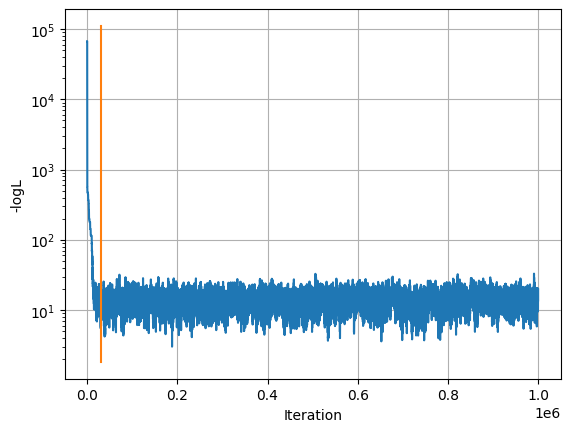

In [6]:
i_burnin = 30000

plt.figure()
plt.semilogy(-1*logL_post)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('-logL')
plt.plot([i_burnin,i_burnin],plt.ylim())
plt.show()

In [7]:
m_post_sample = m_post_sample[i_burnin:]
logL_post = logL_post[i_burnin:]

<function matplotlib.pyplot.show(close=None, block=None)>

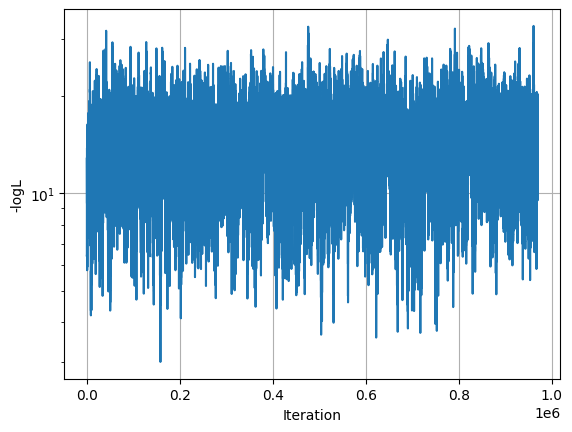

In [8]:
plt.figure()
plt.semilogy(-1*logL_post)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('-logL')
plt.show

In [9]:
plAutoCorr=False
if plAutoCorr:
    plt.subplot(3,1,1)
    plt.acorr(logL_post.flatten()-np.mean(logL_post),maxlags=1000)
    im=10
    plt.subplot(3,1,2)
    plt.acorr(m_post_sample[:,im]-np.mean(m_post_sample[:,im]),maxlags=1000)
    plt.title('m[%d]' % im)
    im=20
    plt.subplot(3,1,3)
    plt.acorr(m_post_sample[:,im]-np.mean(m_post_sample[:,im]),maxlags=1000)
    plt.title('m[%d]' % im)
    plt.tight_layout()

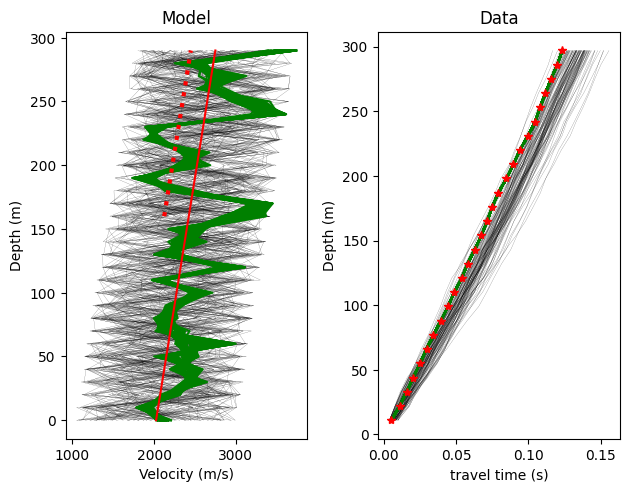

In [10]:

ns_prior = m_prior_sample.shape[0]
ns_post = m_post_sample.shape[0]
ns = np.min([ns_prior,ns_post])

# create an integer array from 0 to ns_prior in ns steps
i_prior = np.floor(np.linspace(0,ns_prior,ns)).astype(int)
# create an integer array from 0 to ns_post in ns steps
i_post = np.floor(np.linspace(0,ns_post,ns)).astype(int)
    
i_reservoir = np.where(z>150)[0]

plt.figure
for i in range(0,ns,int(np.ceil(ns/100))):
    plt_model(m_prior_sample[i_prior[i]], color='k', lw=0.1)
for i in range(0,ns,int(np.ceil(ns/100))):
    plt_model(m_post_sample[i_prior[i]], color='g', lw=1.5)
plt.subplot(1,2,1)
plt.plot(m0,z,'r-')
plt.plot(m0[i_reservoir]-300,z[i_reservoir],'r:',linewidth=3)
plt.title('Model')
plt.subplot(1,2,2)
plt.plot(d_obs,z_data,'r*')
plt.title('Data')
plt.show()

In [11]:
def nlay_res(m_real):
    i_reservoir = np.where(z>150)[0]
    n_res = len(np.where((m_real[i_reservoir]-m0[i_reservoir])<-300)[0])
    return n_res

m_real = m_post_sample[0]
n_res = nlay_res(m_real)

thickres_prior  = []
thickres_post = []
for i in range(0,ns,int(np.ceil(ns/1000))):
    n=nlay_res(m_prior_sample[i_prior[i]])
    thickres_prior.append(n*dz)
for i in range(0,ns,int(np.ceil(ns/1000))):
    n=nlay_res(m_post_sample[i_prior[i]])
    thickres_post.append(n*dz)
thickres_prior=np.array(thickres_prior)
thickres_post=np.array(thickres_post)

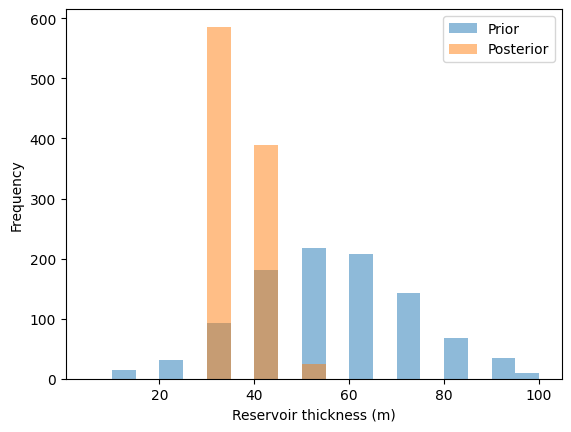

In [12]:
plt.figure()
plt.hist(thickres_prior, bins=np.arange(5,105,5), alpha=0.5, label='Prior')
plt.hist(thickres_post, bins=np.arange(5,105,5), alpha=0.5, label='Posterior')
plt.xlabel('Reservoir thickness (m)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [13]:
th=50
P_prior = len(np.where(thickres_prior>=th)[0])/len(thickres_prior)
print('P(Reservoir thickness >= %fm|prior) = %4.3f' % (th,P_prior)) 
P_post = len(np.where(thickres_post>=th)[0])/len(thickres_post)
print('P(Reservoir thickness >= %fm|post) = %4.3f' % (th,P_post)) 

P(Reservoir thickness >= 50.000000m|prior) = 0.681
P(Reservoir thickness >= 50.000000m|post) = 0.025
